# 冲激响应与频率响应

In [4]:
%matplotlib inline
import pylab as pl
import numpy as np
import matplotlib
from scipy import signal

线性时不变系统可以使用其冲激响应或者频率响应描述。

$$H(s) = \frac{0.1 s - 0.1}{s^2 + 2 s + 3}$$

下面使用`signal.impulse()`计算上面系统$H(s)$的冲激响应。

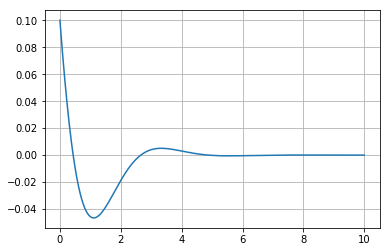

In [32]:
b = [0.1, -0.1]
a = [1, 2, 3]

period = 0.001
t = np.arange(0, 10, period)
_, ir = signal.impulse((b, a), T=t)
pl.plot(t, ir, label="impulse")
pl.grid();

下面的`impulse_to_frequency_response()`通过FFT将冲激响应转换为频率响应，并与`signal.freqs()`计算的理论频率响应值比较：

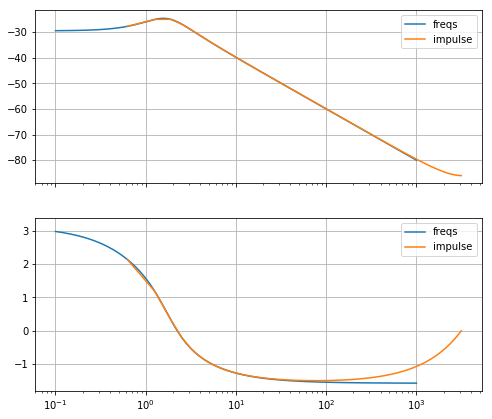

In [36]:
def impulse_to_frequency_response(t, ir, length=None):
    if length is None:
        length = len(ir)
    period = t[1] - t[0]
    omega = np.fft.rfftfreq(length, period) * 2 * np.pi
    fr = np.fft.rfft(ir, n=length) * period
    return omega, fr

def db(h):
    return 20 * np.log10(np.abs(h))

def compare_frequency_response(omegas, hs, labels):
    fig, axes = pl.subplots(2, 1, sharex=True, figsize=(8, 7))
    for omega, h, label in zip(omegas, hs, labels):
        axes[0].semilogx(omega, db(h), label=label)
        axes[1].semilogx(omega, np.angle(h), label=label)
    for ax in axes:
        ax.grid()
        ax.legend()
        
omega1 = np.logspace(-1, 3, 1000)
_, h1 = signal.freqs(b, a, omega1)

omega2, h2 = impulse_to_frequency_response(t, ir)
compare_frequency_response([omega1, omega2], [h1, h2], ["freqs", "impulse"])

可以观察到二者在高频段的相位逐渐出现偏差,而低频段`impulse`的数据不足。对于数据不足可以通过在冲激响应之后添补0，即增加FFT的长度解决。

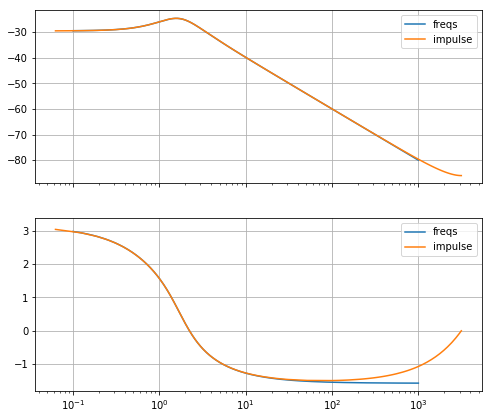

In [39]:
omega3, h3 = impulse_to_frequency_response(t, ir, length=100000)
compare_frequency_response([omega1, omega3], [h1, h3], ["freqs", "impulse"])

而高频的相位误差可以通过增加取样频率解决：

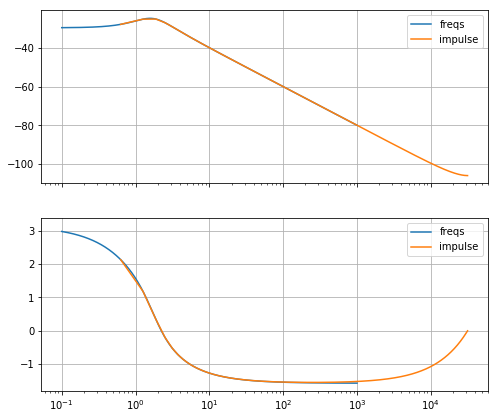

In [41]:
period = 0.0001
t4 = np.arange(0, 10, period)
_, ir4 = signal.impulse((b, a), T=t4)
omega4, h4 = impulse_to_frequency_response(t4, ir4)
compare_frequency_response([omega1, omega4], [h1, h4], ["freqs", "impulse"])

## 在频域进行系统识别

如果通过实验测得系统的一组频率响应，可以使用`scipy.optimize.minimize()`计算出系统的传递函数系数。下面通过8点频率响应值计算出级数不同的3个传递函数的系数：

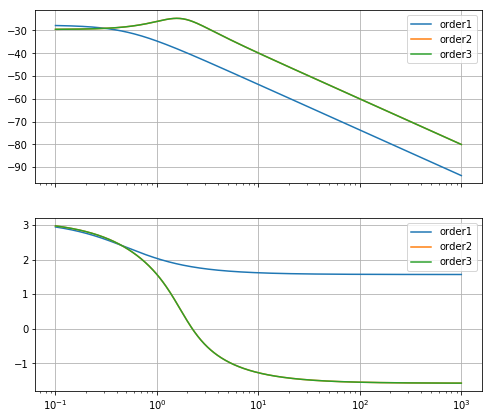

In [51]:
from scipy import optimize

def get_ba(p):
    return np.r_[0, p[:len(p)//2]], np.r_[1, p[len(p)//2:]]

def plot_response(res, omega):
    fig, axes = pl.subplots(figsize=(12, 6))
    for p in res:
        b, a = get_ba(p)
        _, resp = signal.freqs(b, a, omega)
        axes.loglog(omega, np.abs(resp))
    
def error(p, omegas, responses):
    b, a = get_ba(p)
    _, resp = signal.freqs(b, a, omegas)
    return (np.abs(resp - responses)**2).mean()

omega = np.logspace(-1, 3, 8)
_, h = signal.freqs(b, a, omega)
args = omega, h

r1 = optimize.minimize(error, [1, 1], args=args)
r2 = optimize.minimize(error, [1, 1, 1, 1], args=args)
r3 = optimize.minimize(error, [1, 1, 1, 1, 1, 1], args=args)

omega2 = np.logspace(-1, 3, 500)
b1, a1 = get_ba(r1.x)
b2, a2 = get_ba(r2.x)
b3, a3 = get_ba(r3.x)
_, h1 = signal.freqs(b1, a1, omega2)
_, h2 = signal.freqs(b2, a2, omega2)
_, h3 = signal.freqs(b3, a3, omega2)

compare_frequency_response([omega2] * 3, [h1, h2, h3], ["order1", "order2", "order3"])

In [52]:
b2, a2

(array([ 0.        ,  0.09991928, -0.10001922]),
 array([ 1.        ,  1.99959954,  2.99970942]))

## 在时域进行系统识别

在频域测量系统的响应需要输入不同频率的正弦波，并计算输入和输入之间的振幅比和相位差，测量起来比较麻烦，而系统的脉冲响应则无法直接测得。此时我们可以测量系统的阶跃响应。下面使用`signal.step()`计算阶跃响应，并添加一定的测量噪声。

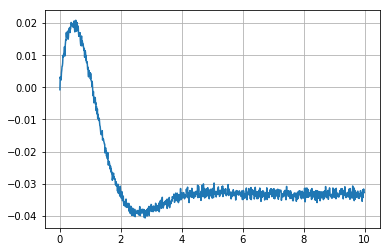

In [60]:
t = np.arange(0, 10, 0.01)
_, sr = signal.step((b, a), T=t)
sr += np.random.normal(0, 0.001, len(t))
pl.plot(t, sr)
pl.grid();

然后使用优化库找到最符合上面的阶跃响应的系统的系数。

In [56]:
def plot_step_response(res, t):
    fig, axes = pl.subplots(figsize=(12, 6))
    for p in res:
        b, a = get_ba(p)
        _, resp = signal.step((b, a), T=t)
        axes.plot(t, resp)
    return axes
    
def error_step_response(p, t, response):
    b, a = np.r_[0, p[:len(p)//2]], np.r_[1, p[len(p)//2:]]
    _, resp = signal.step((b, a), T=t)
    return ((resp - response)**2).mean()

args = t, sr

tr1 = optimize.minimize(error_step_response, [1, 1], args=args)
tr2 = optimize.minimize(error_step_response, [1, 1, 1, 1], args=args, tol=1e-10)
tr3 = optimize.minimize(error_step_response, [1, 1, 1, 1, 1, 1], args=args)
get_ba(tr2.x)

C:\Anaconda3\lib\site-packages\scipy\signal\filter_design.py:1452: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


(array([ 0.        ,  0.10031599, -0.1003608 ]),
 array([ 1.        ,  2.01585575,  3.00359599]))

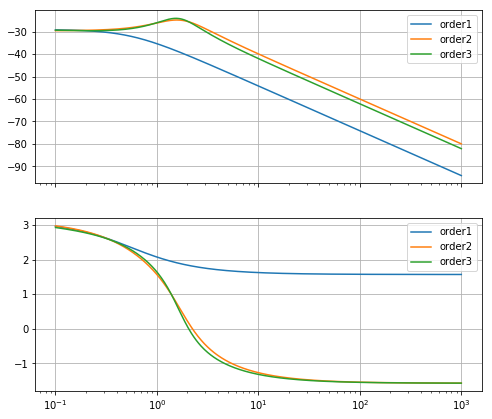

In [58]:
omega2 = np.logspace(-1, 3, 500)
b1, a1 = get_ba(tr1.x)
b2, a2 = get_ba(tr2.x)
b3, a3 = get_ba(tr3.x)
_, h1 = signal.freqs(b1, a1, omega2)
_, h2 = signal.freqs(b2, a2, omega2)
_, h3 = signal.freqs(b3, a3, omega2)

compare_frequency_response([omega2] * 3, [h1, h2, h3], ["order1", "order2", "order3"])

比较二阶拟合的拟合结果与真实的系统响应：

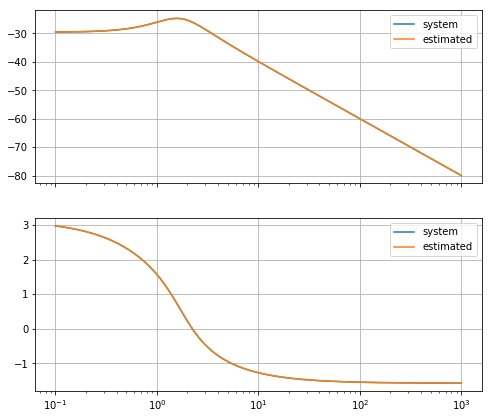

In [59]:
omega2 = np.logspace(-1, 3, 500)
_, h = signal.freqs(b, a, omega2)
compare_frequency_response([omega2] * 2, [h, h2], ["system", "estimated"])